## QCNN implementation

In [1]:
import matplotlib.pyplot as plt
from torchquantum.plugins import op_history2qasm
from source.models import *
from source.state_prep import *
from source.train_funcs import *

### Calling model and training

In [2]:
circuit_builder = MajoranaCircuit
model = QCNN_Classical(circuit_builder) # QCNN model that we're using
train_load, train_lab, test_load, test_lab = generate_data(model, n_points=500, train_split=0.8)
model, preds = train(model, train_load, train_lab, epochs=10, lr=5e-3)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 0.6121456623077393
epoch: 1, loss: 0.08024219423532486
epoch: 2, loss: 0.0207962803542614
epoch: 3, loss: 0.007496439851820469
epoch: 4, loss: 0.003529344452545047
epoch: 5, loss: 0.0018987938528880477
epoch: 6, loss: 0.0009849081980064511
epoch: 7, loss: 0.0005234333220869303
epoch: 8, loss: 0.0003093569539487362
epoch: 9, loss: 0.0002295621670782566
epoch: 10, loss: 0.00016771958325989544
epoch: 11, loss: 0.00012564957432914525
epoch: 12, loss: 9.501630120212212e-05
epoch: 13, loss: 7.269854540936649e-05
epoch: 14, loss: 5.506258821696974e-05
epoch: 15, loss: 4.1165676520904526e-05
epoch: 16, loss: 3.0099243303993717e-05
epoch: 17, loss: 2.173362736357376e-05
epoch: 18, loss: 1.4573462067346554e-05
epoch: 19, loss: 8.234715096477885e-06


### Testing the trained model

In [3]:
preds, accuracy = test(model, test_load, test_lab)
print(accuracy)

0.98


### Plot results and visualize phase diagram

Text(0.5, 1.0, 'QCNN classification (1 = trivial, 0 = topological)')

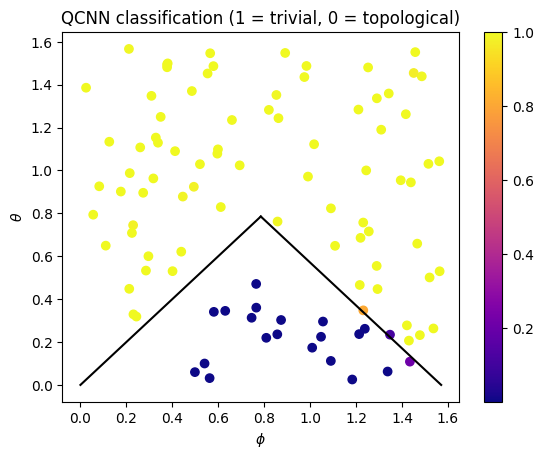

In [4]:
f, ax = plt.subplots()
phis = []
thetas = []
pred_s = []
for i, angles in enumerate(test_load):
    pred = preds[i].detach().numpy()
    theta = angles[0].detach().numpy()
    phi = angles[1].detach().numpy()
    phis.append(phi)
    thetas.append(theta)
    pred_s.append(pred)

points = ax.scatter(phis, thetas, c=pred_s,cmap='plasma')
f.colorbar(points)
ax.plot(np.linspace(0, np.pi/4, 50), np.linspace(0, np.pi/4, 50), c = 'k')
ax.plot(np.linspace(np.pi/4, np.pi/2, 50), np.ones(50)*np.pi/2-np.linspace(np.pi/4, np.pi/2, 50), c = 'k')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\theta$')
ax.set_title('QCNN classification (1 = trivial, 0 = topological)')

In [5]:
# qiskit_circuit = op_history2qasm(qdev.n_wires, qdev.op_history)